# Proyecto 1 Minería de Datos.
Importacion de librerias. 

In [25]:
import pyreadstat
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ks_2samp, anderson, norm
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from typing import *
import sklearn as sklearn
from sklearn import datasets
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree, export_text
from statsmodels.graphics.gofplots import qqplot
from yellowbrick.regressor import ResidualsPlot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from kmodes.kprototypes import KPrototypes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from sklearn.decomposition import PCA


from tqdm import tqdm
import sys
import warnings

Exportación de los datos de bases de datos obtenidas de las [Estadísticas Hospitalarias](https://www.ine.gob.gt/estadisticas-hospitalarias/) del Instituto Nacional de Estadística de Guatemala (INE).

Cada archivo tiene los datos pertenecientes a un año en específico. Se leen los datos y se almacenan en una lista. 


In [2]:
dfs = []

for i in range(2012, 2023):
    df, metadata = pyreadstat.read_sav(f'./data/{i}.sav', encoding="latin1")
    dfs.append(df)

Se usa el primer dataframe como el dataframe  principal y los demas se fusionan con este. Pero antes se organiza la columns para reestructurar la columna "GRUPETNICO" para adaptarla a su contraparte "PPERTENENCIA" que es utilizada en dataframes modernos. 

In [3]:
df = dfs[-1]
for year in dfs[:-1]:
    if 'GRUPETNICO' in year.columns:
        year.rename(columns={'GRUPETNICO': 'PPERTENENCIA'}, inplace = True)
        year['PPERTENENCIA'] = year['PPERTENENCIA'].replace({1: 6, 2: 4})
    df = df._append(year)

df

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,MUNIRESIDEN,CAUFIN,CONDIEGRES,TRATARECIB
0,2022.0,7.0,1.0,2.0,9.0,1.0,2.0,13.0,1301,A010,1.0,1.0
1,2022.0,5.0,1.0,2.0,9.0,1.0,3.0,1.0,0108,A010,1.0,1.0
2,2022.0,4.0,1.0,2.0,9.0,1.0,3.0,10.0,1010,A010,1.0,1.0
3,2022.0,1.0,1.0,1.0,9.0,1.0,2.0,13.0,1303,A010,1.0,1.0
4,2022.0,8.0,1.0,2.0,4.0,3.0,3.0,18.0,1804,A010,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
228466,2021.0,5.0,9999.0,1.0,9.0,999.0,9.0,99.0,9999,Z380,1.0,1.0
228467,2021.0,5.0,9999.0,1.0,9.0,999.0,9.0,99.0,9999,Z380,1.0,1.0
228468,2021.0,5.0,9999.0,1.0,9.0,999.0,9.0,99.0,9999,Z380,1.0,1.0
228469,2021.0,6.0,3.0,1.0,1.0,3.0,1.0,99.0,9999,Z380,1.0,1.0


In [4]:
dfCopy = df.copy()

Se verifica la cantidad de elementos nulos en el dataframe.

In [5]:
# Contar los valores NA por columna
na_count = df.isna().sum()

# Filtrar columnas con valores NA
columns_with_na = na_count[na_count > 0]

print("Cantidad de valores NA por columna:")
print(na_count)

print("\nColumnas con valores NA:")
print(columns_with_na)

Cantidad de valores NA por columna:
AÑO             0
MES             0
DIASESTANCIA    0
SEXO            0
PPERTENENCIA    0
EDAD            0
PERIODOEDA      0
DEPTORESIDEN    0
MUNIRESIDEN     0
CAUFIN          0
CONDIEGRES      0
TRATARECIB      0
dtype: int64

Columnas con valores NA:
Series([], dtype: int64)


Se observan los tipos de cada una de las variables del dataframe. 

In [6]:
infoSumary = df.info()
infoSumary

<class 'pandas.core.frame.DataFrame'>
Index: 2499795 entries, 0 to 228470
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   AÑO           float64
 1   MES           float64
 2   DIASESTANCIA  float64
 3   SEXO          float64
 4   PPERTENENCIA  float64
 5   EDAD          float64
 6   PERIODOEDA    float64
 7   DEPTORESIDEN  float64
 8   MUNIRESIDEN   object 
 9   CAUFIN        object 
 10  CONDIEGRES    float64
 11  TRATARECIB    float64
dtypes: float64(10), object(2)
memory usage: 247.9+ MB


Descripción de los datos de las variables en el dataframe. Gracias a esto se identificó que de forma erronea existen registros de personas con 999.0 años. 

In [7]:
df.describe()

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,CONDIEGRES,TRATARECIB
count,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06
mean,2.017180e+03,6.432386e+00,3.147715e+02,1.631465e+00,5.756676e+00,4.346715e+01,2.846542e+00,6.830349e+00,1.009392e+00,1.477632e+00
std,3.026397e+00,3.407258e+00,1.740414e+03,6.361045e-01,2.573496e+00,9.048782e+01,8.158357e-01,9.825729e+00,2.121092e-01,7.243745e-01
min,2.012000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.015000e+03,3.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.700000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,2.017000e+03,6.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,3.300000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,2.020000e+03,9.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00,5.500000e+01,3.000000e+00,1.200000e+01,1.000000e+00,2.000000e+00
max,2.022000e+03,1.200000e+01,9.999000e+03,9.000000e+00,9.000000e+00,9.990000e+02,9.000000e+00,9.900000e+01,9.000000e+00,9.000000e+00


En base a esto, se decidió eliminar los valores con la edad erronea

In [8]:
df = df.loc[df['EDAD'] <= 120.0]

Se mide la normalidad de las variables númericas que posee el dataframe (DIASESTANCIA y EDAD) mediante el uso de anderson y un histograma. En base a estó se rechazó la hipotesis nula de la normalidad para ambas variables. 

In [9]:
# Se hace una funcion que haga pruebas para las variables cuantitativas
from scipy.stats import kstest
RESET = "\033[0m"
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
CYAN = "\033[96m"


def test_normal(colum, data=df):
    # Supongamos que 'data' es tu DataFrame y 'column' es la columna que quieres verificar
    
    # Realizar la prueba de Kolmogorov-Smirnov
    stat, p_value = kstest(data[colum], 'norm')

    # Imprimir los resultados
    print(f'Estadística de prueba: {stat}, Valor p: {p_value}')

    # Interpretar el resultado
    alpha = 0.05
    if p_value > alpha:
        print('\033[92m' + 'No podemos rechazar la hipótesis nula: la variable parece seguir una distribución normal.' + '\033[0m')
        return True
    else:
        print('\033[91m' + 'Rechazamos la hipótesis nula: la variable no sigue una distribución normal.' + '\033[0m')
        return False




Para la variable DIASESTANCIA 


Mediante prueba de Kolmogorov-Smirnov
Estadística de prueba: 0.8413447460685429, Valor p: 0.0
Rechazamos la hipótesis nula: la variable no sigue una distribución normal.
Mediante prueba de Anderson
Columna DIASESTANCIA: Estadística=921449.2652
La columna DIASESTANCIA no sigue una distribución normal al 15.0% de confianza.


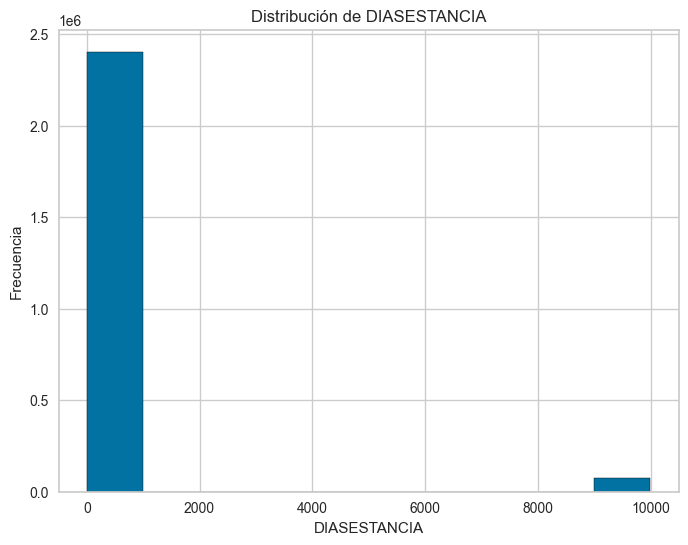

Para la variable EDAD 


Mediante prueba de Kolmogorov-Smirnov
Estadística de prueba: 0.9233809799777276, Valor p: 0.0
Rechazamos la hipótesis nula: la variable no sigue una distribución normal.
Mediante prueba de Anderson
Columna EDAD: Estadística=24592.1135
La columna EDAD no sigue una distribución normal al 15.0% de confianza.


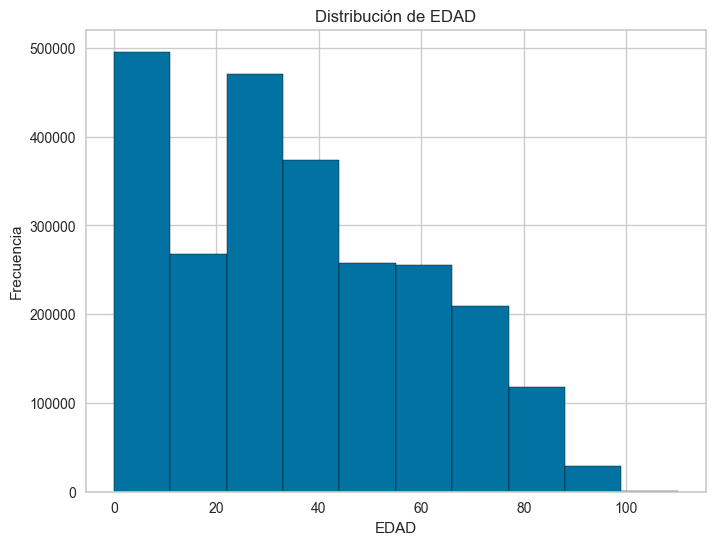

In [10]:
for column in ['DIASESTANCIA', 'EDAD']:
    print('\033[96m' + 'Para la variable', column, '\033[0m')
    print('\n')
    print('Mediante prueba de Kolmogorov-Smirnov')
    is_aproved = test_normal(column)

    print('Mediante prueba de Anderson')
    result = anderson(df[column])
    statistic = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level

    print(f'Columna {column}: Estadística={statistic:.4f}')

    # Comparar la estadística con los valores críticos
    for i, alpha in enumerate([15.0, 10.0, 5.0, 2.5, 1.0]):
        if statistic > critical_values[i]:
            print(f'\033[91mLa columna {column} no sigue una distribución normal al {alpha}% de confianza.\033[0m')
            break
    else:
        print(f'\033[92mLa columna {column} sigue una distribución normal al 1% de confianza.\033[0m')


    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()


Ahora con las variables categoricas. Se realizan tablas de frecuencia para cada una, se evalua la moda. Y para las que tengan menos de 11 categorías se realizó un gráfico de barras en base a las frecuencias. 

 Tabla de frecuencias para la variable AÑO 
+--------+------------+---------------------+-------------------------------+
|  AÑO   | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+--------+------------+---------------------+-------------------------------+
| 2019.0 |   285712   |       11.52%        |            11.52%             |
| 2020.0 |   260655   |       10.51%        |            22.03%             |
| 2016.0 |   249061   |       10.05%        |            32.08%             |
| 2018.0 |   237943   |        9.6%         |            41.68%             |
| 2015.0 |   229140   |        9.24%        |            50.92%             |
| 2021.0 |   227632   |        9.18%        |             60.1%             |
| 2017.0 |   222555   |        8.98%        |            69.08%             |
| 2014.0 |   205157   |        8.28%        |            77.36%             |
| 2022.0 |   193752   |        7.82%        |            85.18%             |
| 2013.0 |   185435 

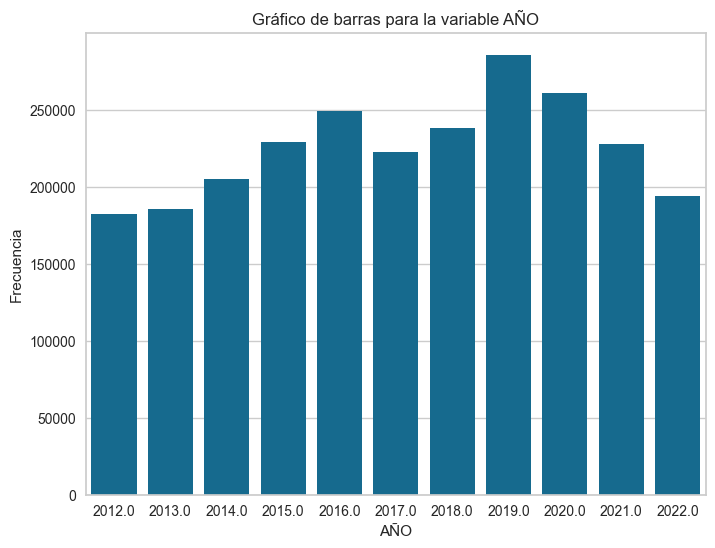


 Tabla de frecuencias para la variable MES 
+------+------------+---------------------+-------------------------------+
| MES  | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+------+------------+---------------------+-------------------------------+
| 5.0  |   217412   |        8.77%        |             8.77%             |
| 3.0  |   217048   |        8.75%        |            17.52%             |
| 7.0  |   216136   |        8.72%        |            26.24%             |
| 8.0  |   215411   |        8.69%        |            34.93%             |
| 9.0  |   210367   |        8.49%        |            43.42%             |
| 10.0 |   209176   |        8.44%        |            51.86%             |
| 1.0  |   207199   |        8.36%        |            60.22%             |
| 4.0  |   203195   |        8.2%         |            68.42%             |
| 6.0  |   201684   |        8.14%        |            76.56%             |
| 2.0  |   201683   |        8.14%        |

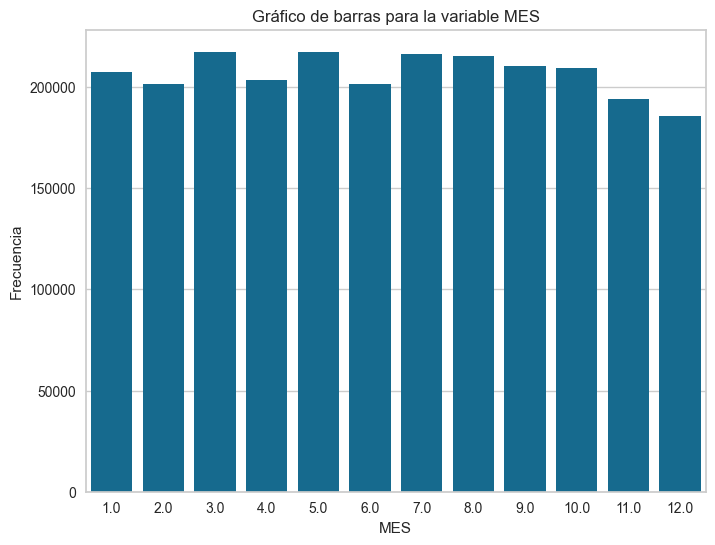


 Tabla de frecuencias para la variable SEXO 
+------+------------+---------------------+-------------------------------+
| SEXO | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+------+------------+---------------------+-------------------------------+
| 2.0  |  1504244   |       60.68%        |            60.68%             |
| 1.0  |   967518   |       39.03%        |            99.71%             |
| 9.0  |    7387    |        0.3%         |             100%              |
+------+------------+---------------------+-------------------------------+
 La moda es 2.0 

Gráfico de barras para la variable 'SEXO':


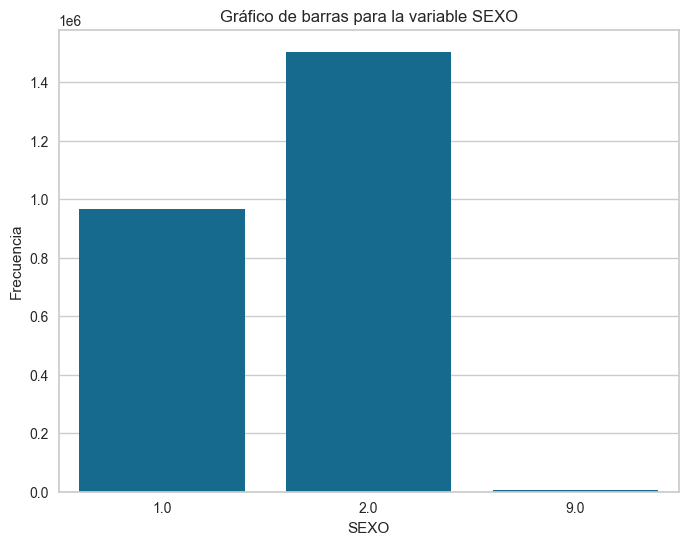


 Tabla de frecuencias para la variable PPERTENENCIA 
+--------------+------------+---------------------+-------------------------------+
| PPERTENENCIA | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+--------------+------------+---------------------+-------------------------------+
|     4.0      |  1285692   |       51.86%        |            51.86%             |
|     9.0      |   883279   |       35.63%        |            87.49%             |
|     6.0      |   169316   |        6.83%        |            94.32%             |
|     1.0      |   138578   |        5.59%        |            99.91%             |
|     5.0      |    1615    |        0.07%        |            99.98%             |
|     2.0      |    571     |        0.02%        |            100.0%             |
|     3.0      |     98     |        0.0%         |            100.0%             |
+--------------+------------+---------------------+-------------------------------+
 La moda es 4.0 

Gráf

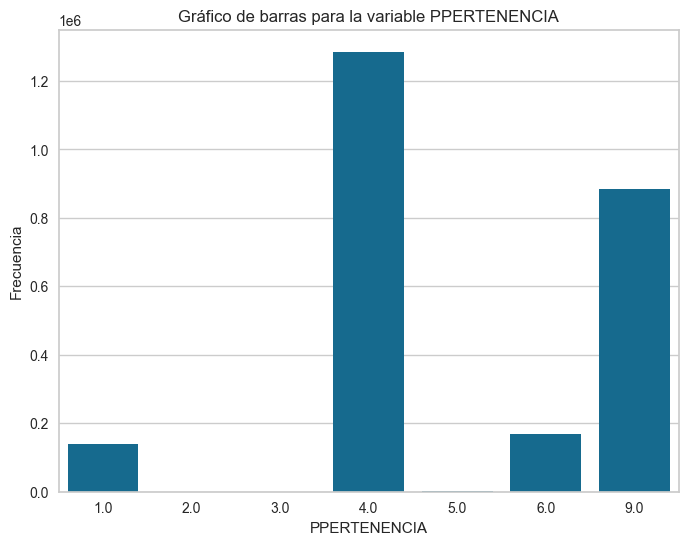


 Tabla de frecuencias para la variable PERIODOEDA 
+------------+------------+---------------------+-------------------------------+
| PERIODOEDA | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+------------+------------+---------------------+-------------------------------+
|    3.0     |  2207638   |       89.05%        |            89.05%             |
|    1.0     |   235978   |        9.52%        |            98.57%             |
|    2.0     |   35533    |        1.43%        |            100.0%             |
+------------+------------+---------------------+-------------------------------+
 La moda es 3.0 

Gráfico de barras para la variable 'PERIODOEDA':


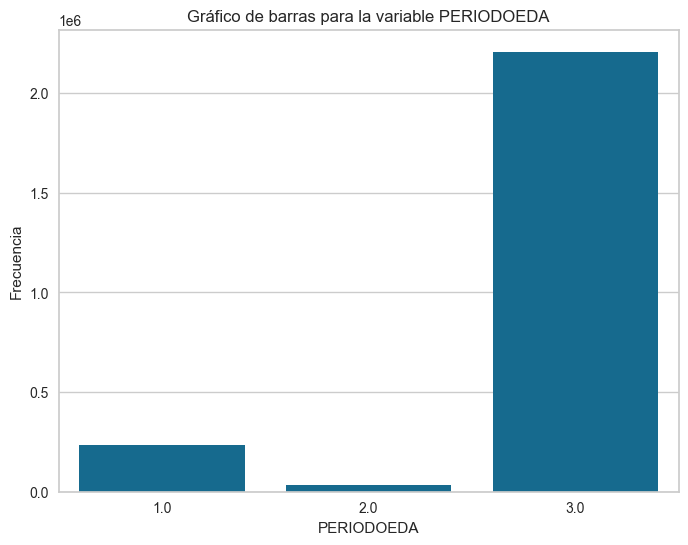


 Tabla de frecuencias para la variable DEPTORESIDEN 
+--------------+------------+---------------------+-------------------------------+
| DEPTORESIDEN | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+--------------+------------+---------------------+-------------------------------+
|     1.0      |  1306626   |        52.7%        |             52.7%             |
|     9.0      |   114989   |        4.64%        |            57.34%             |
|     13.0     |   108791   |        4.39%        |            61.73%             |
|     5.0      |   88329    |        3.56%        |            65.29%             |
|     16.0     |   85206    |        3.44%        |            68.73%             |
|     12.0     |   78100    |        3.15%        |            71.88%             |
|     22.0     |   59428    |        2.4%         |            74.28%             |
|     11.0     |   59270    |        2.39%        |            76.67%             |
|     10.0     |   582

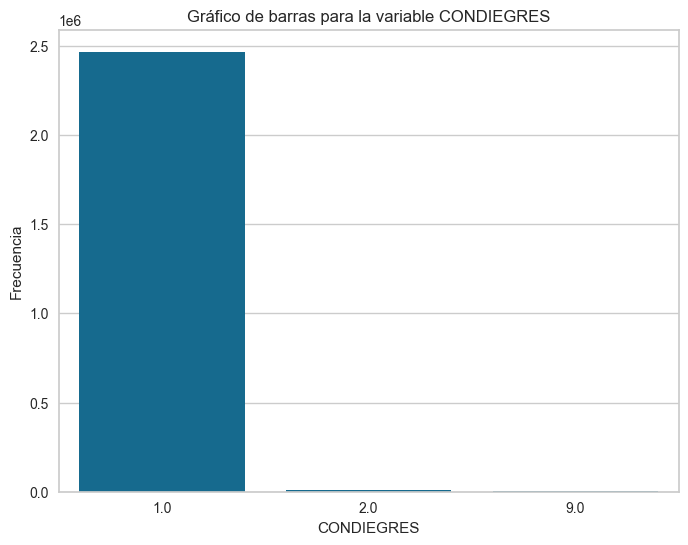


 Tabla de frecuencias para la variable TRATARECIB 
+------------+------------+---------------------+-------------------------------+
| TRATARECIB | Frecuencia | Frecuencia Relativa | Frecuencia Relativa Acumulada |
+------------+------------+---------------------+-------------------------------+
|    1.0     |  1611360   |        65.0%        |             65.0%             |
|    2.0     |   557323   |       22.48%        |            87.48%             |
|    3.0     |   309347   |       12.48%        |            99.96%             |
|    9.0     |    1119    |        0.05%        |             100%              |
+------------+------------+---------------------+-------------------------------+
 La moda es 1.0 

Gráfico de barras para la variable 'TRATARECIB':


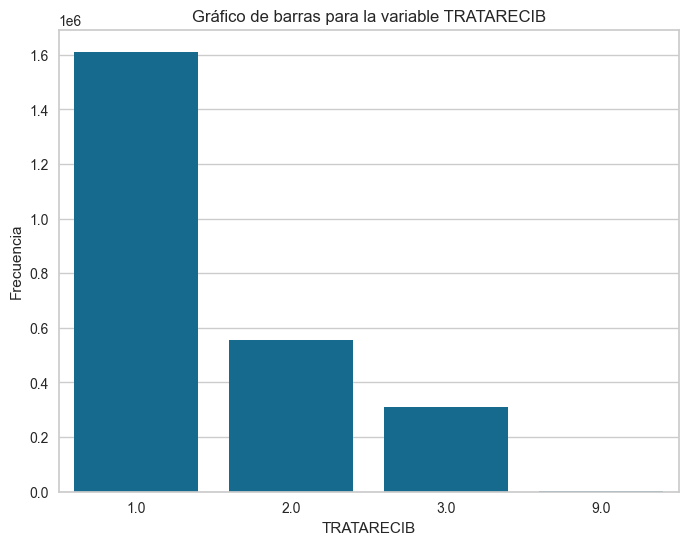

In [11]:
dfCategoricas = df.drop(columns=["DIASESTANCIA", "EDAD"])

moreTo12 = []

def frecuency_table(colum, data= df):
    # Obtener la tabla de frecuencias para la variable 'genres'

    split_genres = data[colum].dropna().astype(str).str.split('|', expand=True).stack()
    split_genres = split_genres[split_genres != ' ']
    split_genres = split_genres[split_genres != '']
    frecuencias = split_genres.value_counts()
    frecuencia_relativa = round(frecuencias / len(split_genres) * 100, 2)
    frecuencia_relativa_acum = frecuencia_relativa.cumsum()
    frecuencia_relativa_acum = frecuencia_relativa_acum.apply(lambda x: f'{round(x, 2) if x<=100 else 100}%')
    frecuencia_relativa = frecuencia_relativa.apply(lambda x: f'{round(x, 2)}%')

    # Convertir la serie resultante en un DataFrame para mejor presentación
    tabla_frecuencias = pd.DataFrame({
        colum: frecuencias.index,
        'Frecuencia': frecuencias.values,
        'Frecuencia Relativa': frecuencia_relativa.values,
        'Frecuencia Relativa Acumulada': frecuencia_relativa_acum.values
    })

    print(CYAN, 'Tabla de frecuencias para la variable', colum, RESET)
    print(tabulate(tabla_frecuencias,  headers='keys', tablefmt='pretty', showindex=False))


for column in dfCategoricas.columns:
    frecuency_table(column, data=dfCategoricas)
    print('\33[92m','La moda es', dfCategoricas[column].mode().values[0], '\33[0m')
    print()

    if dfCategoricas[column].nunique() > 12:
        print('\33[91m', 'La variable tiene más de 12 categorías, no se generará un gráfico de barras.', '\33[0m')
        print()
        moreTo12.append(column)
        continue
    print(f"Gráfico de barras para la variable '{column}':")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=dfCategoricas, x=column)
    plt.title(f'Gráfico de barras para la variable {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()
    print()
    


Para aquellas variables que no pudimos gráficar dado que tenían muchas categorias para que fuera facilmente visualizable. Se les realiza un cambio temporal a varible númerica para poderle realizar un histograma, en que se pueda observar el estado de los datos.

La columna DEPTORESIDEN es numerica


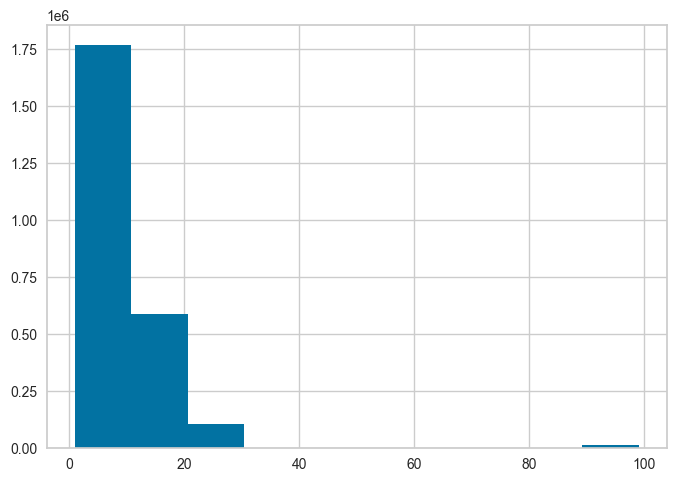

Para la variable MUNIRESIDEN los valores ahora son: 
NA : 0
1301 : 1
0108 : 2
1010 : 3
1303 : 4
1804 : 5
1603 : 6
1230 : 7
0404 : 8
1108 : 9
1606 : 10
0409 : 11
1901 : 12
1312 : 13
1401 : 14
1609 : 15
2203 : 16
1302 : 17
0511 : 18
1327 : 19
0713 : 20
1315 : 21
1305 : 22
1003 : 23
0401 : 24
0103 : 25
0101 : 26
1406 : 27
1801 : 28
0501 : 29
2001 : 30
1419 : 31
1308 : 32
1226 : 33
0115 : 34
1320 : 35
1008 : 36
2211 : 37
1412 : 38
1409 : 39
0412 : 40
1307 : 41
1324 : 42
1105 : 43
1001 : 44
1413 : 45
1310 : 46
1304 : 47
0301 : 48
1415 : 49
0924 : 50
1322 : 51
1332 : 52
0801 : 53
1501 : 54
1319 : 55
1414 : 56
1316 : 57
2300 : 58
1317 : 59
1311 : 60
2205 : 61
1101 : 62
1602 : 63
1601 : 64
1610 : 65
1508 : 66
0502 : 67
1004 : 68
0614 : 69
1611 : 70
1605 : 71
1613 : 72
0719 : 73
1612 : 74
0805 : 75
0110 : 76
0606 : 77
1405 : 78
0111 : 79
0601 : 80
1309 : 81
1017 : 82
0306 : 83
0207 : 84
1107 : 85
1408 : 86
1418 : 87
2208 : 88
0114 : 89
1323 : 90
1217 : 91
0710 : 92
1306 : 93
2202 : 94
0712 : 95

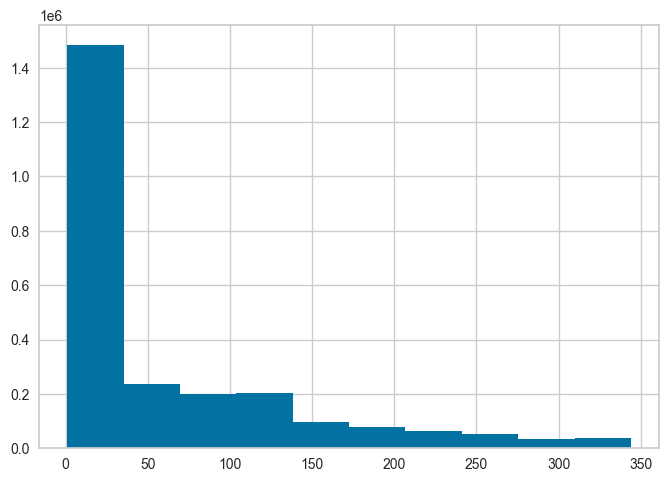

Para la variable CAUFIN los valores ahora son: 
NA : 0
A010 : 1
A020 : 2
A029 : 3
A039 : 4
A042 : 5
A043 : 6
A045 : 7
A047 : 8
A048 : 9
A049 : 10
A059 : 11
A060 : 12
A064 : 13
A068 : 14
A069 : 15
A071 : 16
A072 : 17
A080 : 18
A081 : 19
A082 : 20
A083 : 21
A084 : 22
A090 : 23
A099 : 24
A162 : 25
A169 : 26
A180 : 27
A199 : 28
A309 : 29
A35X : 30
A379 : 31
A38X : 32
A399 : 33
A409 : 34
A412 : 35
A419 : 36
A429 : 37
A449 : 38
A46X : 39
A480 : 40
A484 : 41
A493 : 42
A498 : 43
A499 : 44
A509 : 45
A528 : 46
A539 : 47
A549 : 48
A560 : 49
A562 : 50
A57X : 51
A58X : 52
A600 : 53
A630 : 54
A638 : 55
A64X : 56
A661 : 57
A691 : 58
A809 : 59
A86X : 60
A880 : 61
A89X : 62
A920 : 63
A928 : 64
A94X : 65
A970 : 66
A971 : 67
A979 : 68
A988 : 69
B001 : 70
B002 : 71
B004 : 72
B009 : 73
B019 : 74
B023 : 75
B029 : 76
B059 : 77
B07X : 78
B081 : 79
B084 : 80
B085 : 81
B09X : 82
B159 : 83
B169 : 84
B181 : 85
B199 : 86
B24X : 87
B251 : 88
B270 : 89
B279 : 90
B302 : 91
B309 : 92
B338 : 93
B340 : 94
B348 : 95
B349

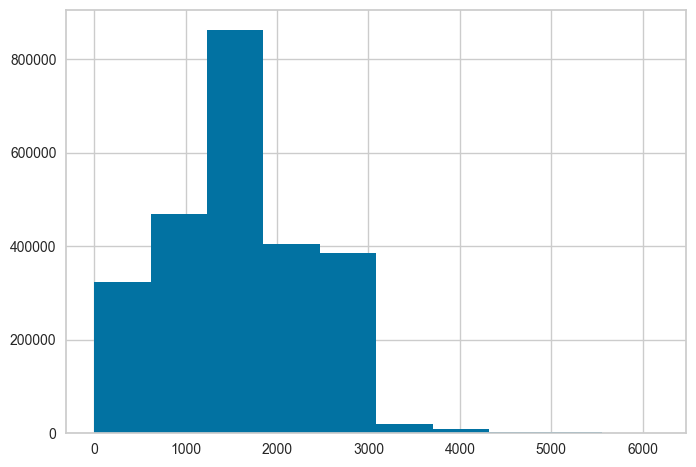

In [12]:
df2 = df.copy()
def change(variable):
    dictValue = {'NA': 0}
    count = 1

    def changeToVariable(x):
        nonlocal count  # Para indicar que count es una variable no local
        if x in dictValue:
            return dictValue[x]
        else:
            dictValue[x] = count
            count += 1
            return dictValue[x]
        
    if not pd.api.types.is_numeric_dtype(df2[variable]):
        df2[variable] = df2[variable].apply(changeToVariable)
    
        print(f'Para la variable {variable} los valores ahora son: ')
        for key, value in dictValue.items():
            print(key, ":", value)
    else:
        print(f"La columna {variable} es numerica")

for variable in moreTo12:
    change(variable=variable)
    df2[variable].hist()
    plt.show()

In [13]:
len(df[df["MUNIRESIDEN"]=='9999']) / len(df) * 100

0.5665653819112929

De lo anterior se logró observar ciertas variables con valores atipicos. Resultado de campos que no se rellenaron o no se tiene registro de un dato correcto. 

- El departamento de residencia un 0.56% no se le identificó un departamento.

- En el municipio de residencia un 0.56% tampoco identificó un municipio válido. 

- El 0.045136% no se específico el tratamiento recibido. 

- Y el 0.297965% no especifico sexo. 

- DIASESTANCIA tiene valores atipicos asociados a 9999 que significa ignorado pero es casi solo 3%

Dado que no es muy grande la cantidad de registros con estos valores para afectar la distribución de los datos, se optó por eliminarlos. 

Otra conclusión a la que se llegó gracias a esté análisis es que más del 99% de los datos en la columna CONDIEGRES da 1. Entonces al ser una varible con una categoria dominante que puede afectar al clustering y a la creación de los modelos de predicción se decidió eliminarla/apartarla del dataset.


In [14]:
dx = df[(df["MUNIRESIDEN"] != '9999') & (df["DEPTORESIDEN"] != 99) & (df["TRATARECIB"] != 9) & (df["SEXO"] != 9) & (df['DIASESTANCIA']<999)]
df = dx.drop(columns=["CONDIEGRES"])
len(df)


2382742

Se pasaron las variables categoricas temporalmente a variables númericas para verificar la correlación que hay entre todas las variables del dataframe. 

Al finalizar se realizó el mapa de calor y la matriz de correlación. El mayor indice de correlación conseguido entre 2 variables fue de 0.467919 en base a eso se logró concluir que en ningún par de variables están realmente correlacionadas de forma significativa entre si. 

In [15]:
df2 = df.copy()
def change(variable):
    dictValue = {'NA': 0}
    count = 1

    def changeToVariable(x):
        nonlocal count  # Para indicar que count es una variable no local
        if x in dictValue:
            return dictValue[x]
        else:
            dictValue[x] = count
            count += 1
            return dictValue[x]
        
    if not pd.api.types.is_numeric_dtype(df2[variable]):
        df2[variable] = df2[variable].apply(changeToVariable)
    
        print(f'Para la variable {variable} los valores ahora son: ')
        for key, value in dictValue.items():
            print(key, ":", value)
    else:
        print(f"La columna {variable} es numerica")

for variable in df2.columns:
    change(variable=variable)

La columna AÑO es numerica
La columna MES es numerica
La columna DIASESTANCIA es numerica
La columna SEXO es numerica
La columna PPERTENENCIA es numerica
La columna EDAD es numerica
La columna PERIODOEDA es numerica
La columna DEPTORESIDEN es numerica
Para la variable MUNIRESIDEN los valores ahora son: 
NA : 0
1301 : 1
0108 : 2
1010 : 3
1303 : 4
1804 : 5
1603 : 6
1230 : 7
0404 : 8
1108 : 9
1606 : 10
0409 : 11
1901 : 12
1312 : 13
1401 : 14
1609 : 15
2203 : 16
1302 : 17
0511 : 18
1327 : 19
0713 : 20
1315 : 21
1305 : 22
1003 : 23
0401 : 24
0103 : 25
0101 : 26
1406 : 27
1801 : 28
0501 : 29
2001 : 30
1419 : 31
1308 : 32
1226 : 33
0115 : 34
1320 : 35
1008 : 36
2211 : 37
1412 : 38
1409 : 39
1307 : 40
1324 : 41
1105 : 42
1001 : 43
1413 : 44
1310 : 45
1304 : 46
0301 : 47
1415 : 48
0924 : 49
1322 : 50
1332 : 51
0801 : 52
1501 : 53
1319 : 54
1414 : 55
1316 : 56
2300 : 57
1317 : 58
1311 : 59
2205 : 60
1602 : 61
1601 : 62
1610 : 63
1508 : 64
0502 : 65
0614 : 66
1611 : 67
1605 : 68
1613 : 69
0719 : 

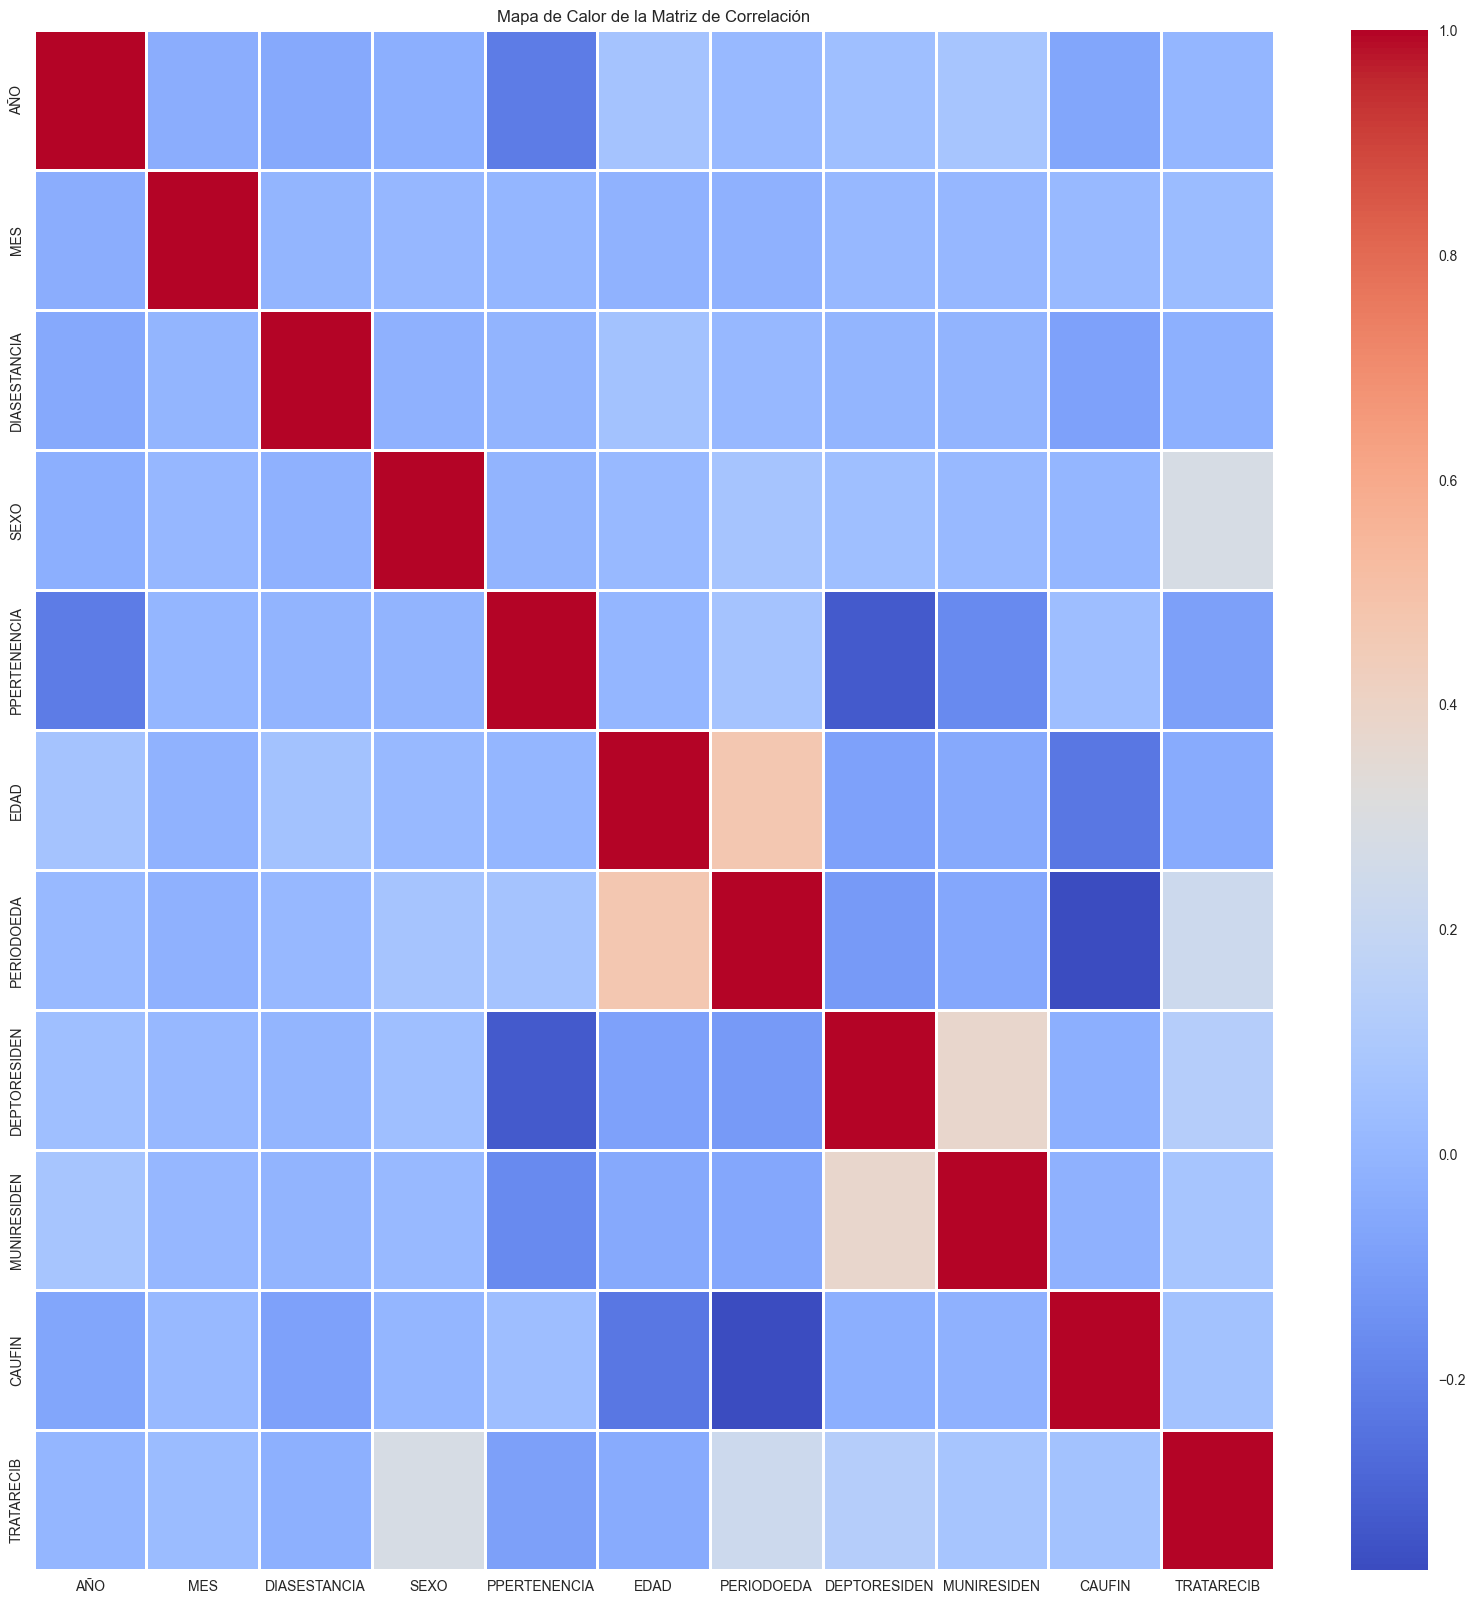

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,MUNIRESIDEN,CAUFIN,TRATARECIB
AÑO,1.000000,-0.035933,-0.050990,-0.032513,-0.219929,0.066049,0.020213,0.045201,0.079141,-0.066559,-0.000373
MES,-0.035933,1.000000,-0.004629,0.006158,0.003620,-0.012049,-0.020040,0.013661,0.005645,0.018125,0.026565
DIASESTANCIA,-0.050990,-0.004629,1.000000,-0.018294,-0.010676,0.062066,0.014708,-0.002562,-0.006914,-0.084505,-0.023885
SEXO,-0.032513,0.006158,-0.018294,1.000000,-0.010606,0.016712,0.070357,0.046332,0.018165,0.004273,0.279050
PPERTENENCIA,-0.219929,0.003620,-0.010676,-0.010606,1.000000,0.001405,0.068356,-0.323490,-0.167469,0.042153,-0.089807
EDAD,0.066049,-0.012049,0.062066,0.016712,0.001405,1.000000,0.473259,-0.081611,-0.050528,-0.233447,-0.046808
PERIODOEDA,0.020213,-0.020040,0.014708,0.070357,0.068356,0.473259,1.000000,-0.108953,-0.064374,-0.369767,0.229706
DEPTORESIDEN,0.045201,0.013661,-0.002562,0.046332,-0.323490,-0.081611,-0.108953,1.000000,0.374738,-0.028557,0.128898
MUNIRESIDEN,0.079141,0.005645,-0.006914,0.018165,-0.167469,-0.050528,-0.064374,0.374738,1.000000,-0.017412,0.077293
CAUFIN,-0.066559,0.018125,-0.084505,0.004273,0.042153,-0.233447,-0.369767,-0.028557,-0.017412,1.000000,0.063541


In [16]:
df_numeric = df2

# Mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(20, 20))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=1)

plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()
correlation_matrix

In [17]:
studyVar = 'TRATARECIB'

In [18]:

# Combine samples
sample_df =  df.sample(frac=0.001, random_state=42)

# Now you can perform your analysis on the sample_df

len(sample_df)

2383

In [19]:
df2 = sample_df.copy()
def change(variable):
    dictValue = {'NA': 0}
    count = 1

    def changeToVariable(x):
        nonlocal count  # Para indicar que count es una variable no local
        if x in dictValue:
            return dictValue[x]
        else:
            dictValue[x] = count
            count += 1
            return dictValue[x]
        
    if not pd.api.types.is_numeric_dtype(df2[variable]):
        df2[variable] = df2[variable].apply(changeToVariable)
    
        print(f'Para la variable {variable} los valores ahora son: ')
        for key, value in dictValue.items():
            print(key, ":", value)
    else:
        print(f"La columna {variable} es numerica")

for variable in df2.columns:
    change(variable=variable)

La columna AÑO es numerica
La columna MES es numerica
La columna DIASESTANCIA es numerica
La columna SEXO es numerica
La columna PPERTENENCIA es numerica
La columna EDAD es numerica
La columna PERIODOEDA es numerica
La columna DEPTORESIDEN es numerica
Para la variable MUNIRESIDEN los valores ahora son: 
NA : 0
0101 : 1
0114 : 2
0920 : 3
1603 : 4
1901 : 5
0916 : 6
0501 : 7
0701 : 8
0108 : 9
0115 : 10
0901 : 11
0513 : 12
1905 : 13
1101 : 14
1215 : 15
1601 : 16
2001 : 17
1805 : 18
1201 : 19
2300 : 20
1301 : 21
0308 : 22
0311 : 23
2201 : 24
1001 : 25
0413 : 26
1703 : 27
0606 : 28
1701 : 29
1804 : 30
0706 : 31
0801 : 32
1712 : 33
1508 : 34
2101 : 35
0401 : 36
1209 : 37
1108 : 38
1214 : 39
1213 : 40
0110 : 41
1109 : 42
1107 : 43
0719 : 44
1504 : 45
0917 : 46
1008 : 47
2009 : 48
1406 : 49
2107 : 50
0602 : 51
0113 : 52
1803 : 53
1801 : 54
0506 : 55
0503 : 56
0502 : 57
1709 : 58
1308 : 59
0304 : 60
1317 : 61
1416 : 62
1326 : 63
0201 : 64
1307 : 65
1501 : 66
0406 : 67
1331 : 68
0713 : 69
2212 : 

In [20]:
X = np.array(df2)
Y = np.array(df2[studyVar])
X.shape

(2383, 11)

In [21]:
random.seed(123)
X_scale = sklearn.preprocessing.scale(X)

pyclustertend.hopkins(X_scale,len(X_scale))

0.20974869471482896

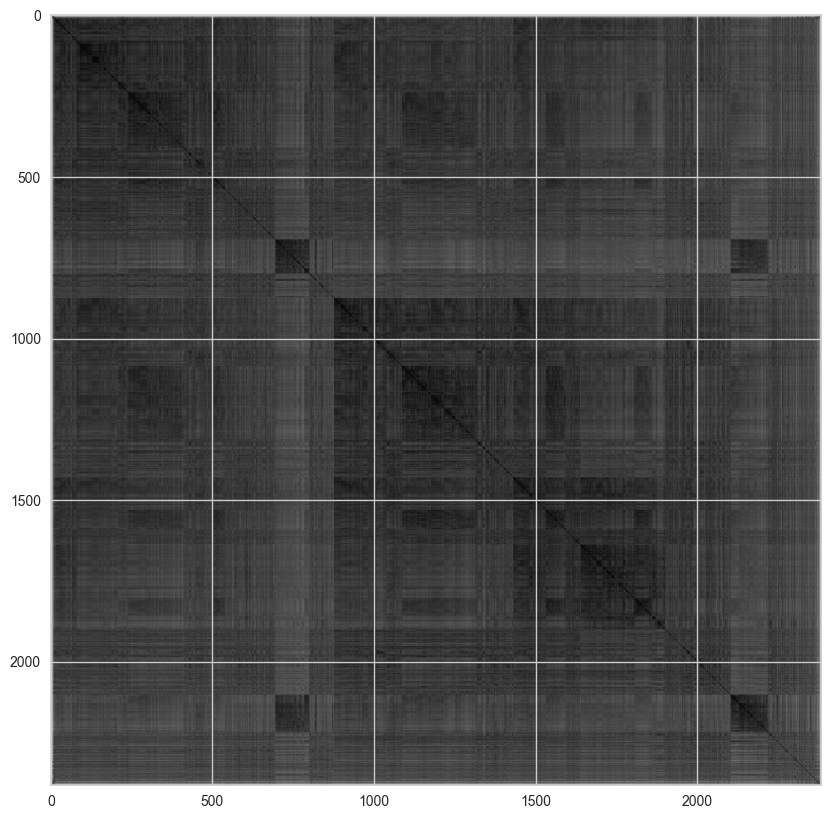

In [22]:
pyclustertend.vat(X_scale)

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):


  File "C:\Users\danar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


elbow value = optimal k: 5  | elbow score: 7,812,227.080


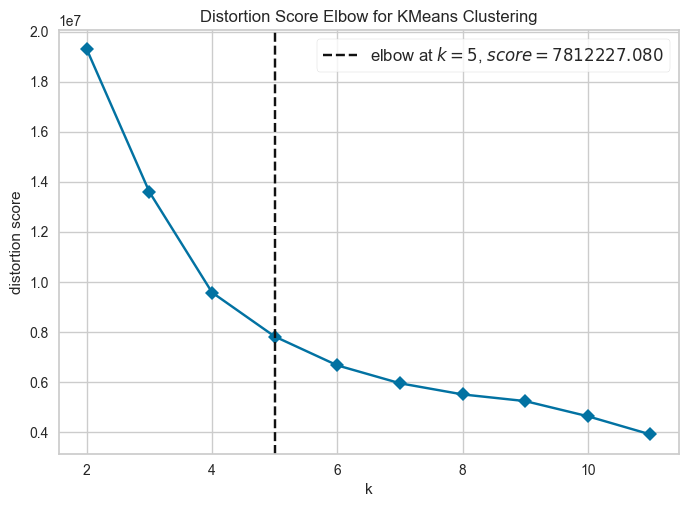

 33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.587


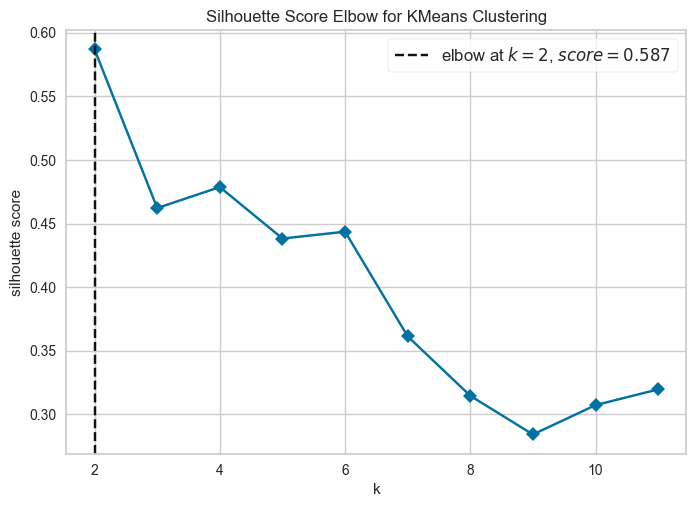

 67%|██████▋   | 2/3 [00:03<00:01,  1.84s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 2  | elbow score: 3,876.516


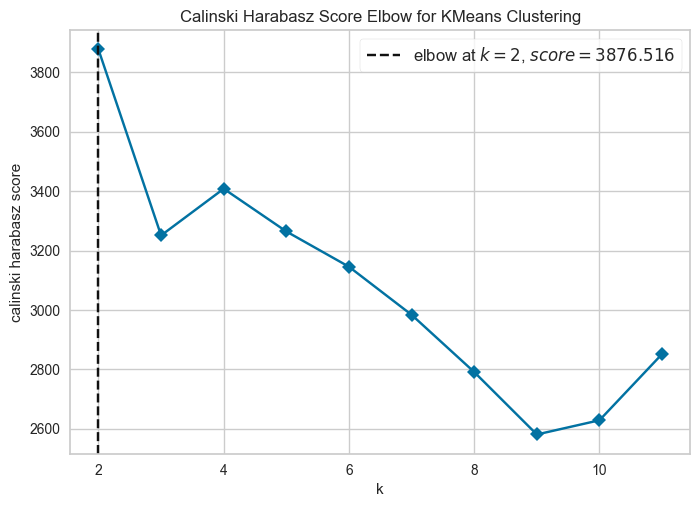

100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


In [26]:
# get it from https://towardsdatascience.com/elbows-and-silhouettes-hands-on-customer-segmentation-in-python-66c2e794c552
warnings.filterwarnings("ignore")
# elbow score plot with Yellowbrick
nK = 12    
RNDN = 42    
def elbowplot(df2, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df2)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  
    
    
    
# call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion

model = KMeans(random_state=RNDN)
_ = [elbowplot(X, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]  